# Hands-On NLP — Class 2

<span style="color:magenta">Group members:</span>

* Junjie CHEN
* Pavlo Poliuha
* Pablo Molla 

## Outline

- Embeddings from scratch

- Classifications with embeddings

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    multiclass,
    naive_bayes,
    neighbors,
    svm,
    tree,
)
# from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

In [3]:
tqdm.pandas()

nltk.download("punkt")

print("sklearn", sklearn.__version__)   # 1.3.2

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

sklearn 1.3.0


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chenchenjunjie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
%config InlineBackend.figure_format="retina"  # For high DPI display

# %load_ext blackcellmagic

In [6]:
DATA = Path("texts")

TEXT_P = DATA 

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

## Getting the data

In [7]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n..."
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic..."


### Tokenizing

In [8]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = DATA / "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [9]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1428,4689305,Q:\n\nCan anyone identify what Chinese mytholo...,"[Q, :, Can, anyone, identify, what, Chinese, m...",942611,51243
woodworking,2461,6729416,Q:\n\nGlue-up for butcher block-style countert...,"[Q, :, Glue-up, for, butcher, block-style, cou...",1390534,32316
robotics,2981,7254006,Q:\n\nHow is this torque value arrived?\n\nI'm...,"[Q, :, How, is, this, torque, value, arrived, ...",1526918,53823
hsm,2329,7364214,"Q:\n\nWhen and why did people stopped using ""n...","[Q, :, When, and, why, did, people, stopped, u...",1445136,62465
health,3412,9148631,Q:\n\nHelp reading an eyeglass prescription: W...,"[Q, :, Help, reading, an, eyeglass, prescripti...",1714930,66007
portuguese,1840,4415251,"Q:\n\nQual a origem da expressão ""o fim da pic...","[Q, :, Qual, a, origem, da, expressão, ``, o, ...",907253,60276


## Vectorization

### 🚧 TODO: How to vectorize text?

- Try counting words in the stackoverflow corpus based on a given vocabulary

- Apply reduction techniques to reduce the dimensionality to 2 dimensions (e.g., PCA)

- Plot the 2D vectors

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

In [11]:
def count_words(tokens, words):
    return sum(token in words for token in tokens)
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)
wc_df = pd.DataFrame(index=df.index)

for word in words:
    wc_df[word] = df.tokens.apply(lambda tokens: tokens.count(word))
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,769,55,6,179,21,4,18,0,27
woodworking,5,7535,0,18,9,0,48,0,2
robotics,0,21,4895,23,22,43,3,0,63
hsm,26,14,2,921,846,1578,28,1,25
health,46,10,1,207,114,6,1576,1,3
portuguese,2,11,3,13,3,1,8,41,14589


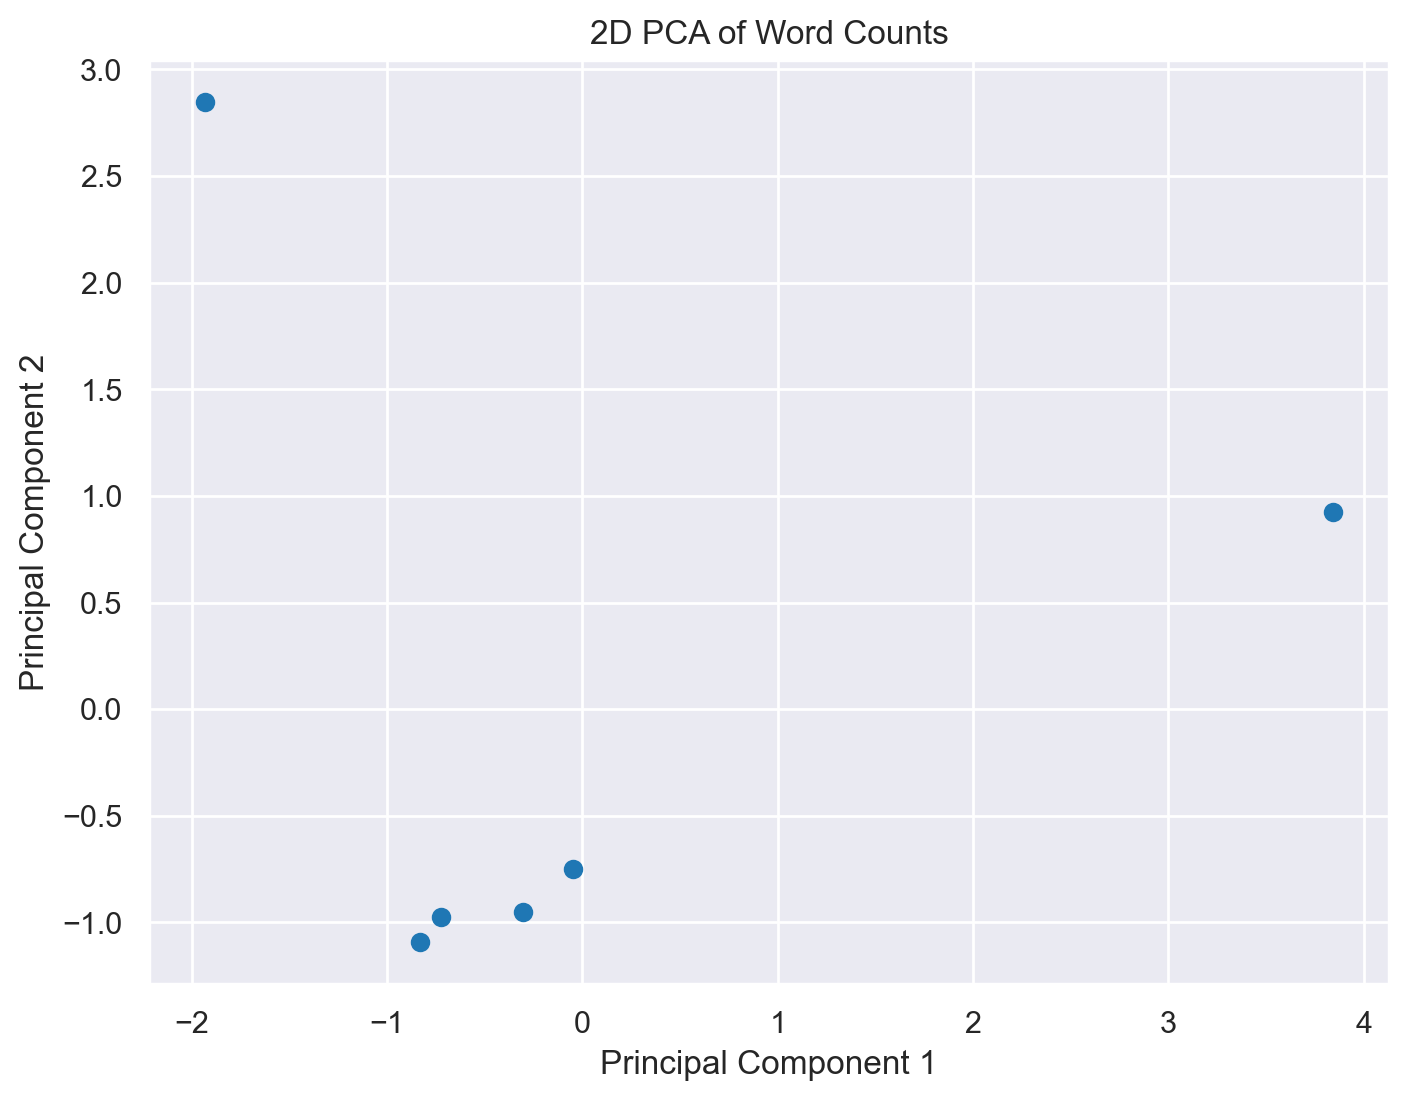

In [44]:
from sklearn.preprocessing import StandardScaler

# Standardizing the data
scaler = StandardScaler()
wc_df_standardized = scaler.fit_transform(wc_df)
# Applying PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(wc_df_standardized)
# Plotting the 2D vectors
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Word Counts')
plt.grid(True)
plt.show()

#### Bag of words

### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    Try with and without the n-gram parameter

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

#### First with a toy example

In [13]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

With the whole vocabulary

In [14]:
# Using CountVectorizer
vectorizer = CountVectorizer()
xs = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(xs.toarray())


vectorizer_2g = CountVectorizer(analyzer='word', ngram_range=(2, 2))
x2gs = vectorizer_2g.fit_transform(corpus)
print(vectorizer_2g.get_feature_names_out())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']


In [15]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.insert(0, "Document", corpus)
cv_df

,Document,and,document,first,is,one,second,the,third,this
0,This is the first document.,0,1,1,1,0,0,1,0,1
1,This document is the second document.,0,2,0,1,0,1,1,0,1
2,And this is the third one.,1,0,0,1,1,0,1,1,1
3,Is this the first document?,0,1,1,1,0,0,1,0,1


With a subset of the vocabulary

In [16]:
vocabulary = ["and", "document", "first"]
vectorizer = CountVectorizer(vocabulary=vocabulary)
xs_subset = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(xs_subset.toarray())

['and' 'document' 'first']
[[0 1 1]
 [0 2 0]
 [1 0 0]
 [0 1 1]]


#### Reprocess the stackoverflow corpora with `CountVectorizer`

In [17]:
# We use the same word divider as in the token library int the convectorizer,Use the same rules for word segmentation
# vocabulary parameter is used to specify the words that will be used in the vectorizer
# word_tokenize parameter is used to split the given text into tokens with respect the stucture
# lowercase parameter = False is used to keep the words as they are
# token_pattern=None is used to disable default tokenization pattern
vectorizer = CountVectorizer(vocabulary=words,tokenizer=word_tokenize, lowercase=False,token_pattern=None)
stackover = vectorizer.fit_transform(df.text)
print(vectorizer.get_feature_names_out())
print(stackover.toarray())

['myth' 'wood' 'robot' 'history' 'science' 'mathematics' 'health'
 'portuguese' 'o']
[[  769    55     6   179    21     4    18     0    27]
 [    5  7535     0    18     9     0    48     0     2]
 [    0    21  4895    23    22    43     3     0    63]
 [   26    14     2   921   846  1578    28     1    25]
 [   46    10     1   207   114     6  1576     1     3]
 [    2    11     3    13     3     1     8    41 14589]]


In [19]:
cv_df = pd.DataFrame(stackover.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.set_index(df.index, inplace=True)
cv_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,769,55,6,179,21,4,18,0,27
woodworking,5,7535,0,18,9,0,48,0,2
robotics,0,21,4895,23,22,43,3,0,63
hsm,26,14,2,921,846,1578,28,1,25
health,46,10,1,207,114,6,1576,1,3
portuguese,2,11,3,13,3,1,8,41,14589


-----------

### Now let's hold the corpus as individual documents

In [20]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [21]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0
...,...,...,...
portuguese.stackexchange_0000001017,"Q:\n\n""pois não"" has an affirmative connotatio...",portuguese,5
portuguese.stackexchange_0000004609,"Q:\n\nPor que ""Teiú"" tem acento?\n\nMonossílab...",portuguese,5
portuguese.stackexchange_0000000484,"Q:\n\nRegional usage of ""guitarra"" and ""violão...",portuguese,5


#### 🚧 TODO: Plot (bar) the number of documents per category

<Axes: xlabel='category'>

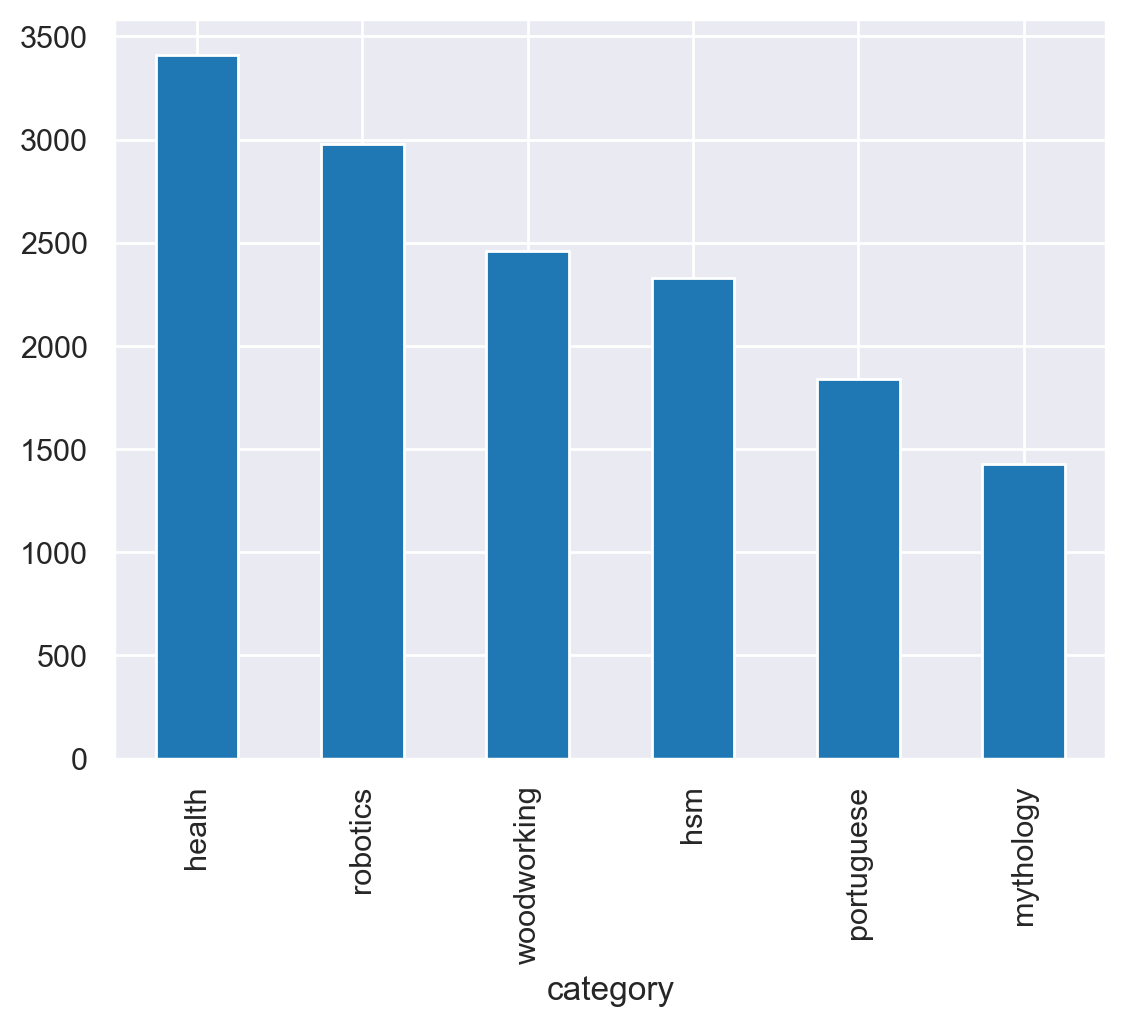

In [22]:
doc_df.value_counts("category").plot(kind="bar")

#### 🚧 TODO: Boxplot the number of tokens per document

* With and without outliers

* Shortly explain the different values presented in a boxplot ([Wikipedia](https://en.wikipedia.org/wiki/Box_plot))

* Are the texts of signifcantly different length? Argue shortly.

In [23]:
# Careful: slow!
tokens_doc_fq = DATA / "tokens_doc.pkl"
try:
    tokens_doc = pd.read_pickle(tokens_doc_fq)
except FileNotFoundError:
    tokens_doc = doc_df.text.progress_map(word_tokenize)
    tokens_doc.to_pickle(tokens_doc_fq)
doc_df['tokens'] = tokens_doc
doc_df["tokens_n"] = doc_df.tokens.map(len)
doc_df

,text,category,cat_id,tokens,tokens_n
id,,,,,
mythology.stackexchange_0000001634,Q:\n\nCan anyone identify what Chinese mytholo...,mythology,0,"[Q, :, Can, anyone, identify, what, Chinese, m...",149
mythology.stackexchange_0000002329,Q:\n\nHave runes ever been used to bring someo...,mythology,0,"[Q, :, Have, runes, ever, been, used, to, brin...",479
mythology.stackexchange_0000001146,Q:\n\nDifferences in the Greek and Roman portr...,mythology,0,"[Q, :, Differences, in, the, Greek, and, Roman...",634
mythology.stackexchange_0000004770,"Q:\n\nWhich cultures have the concept of a ""tr...",mythology,0,"[Q, :, Which, cultures, have, the, concept, of...",761
mythology.stackexchange_0000000516,Q:\n\nWhy did Arawn choose Pwyll to fight Hafg...,mythology,0,"[Q, :, Why, did, Arawn, choose, Pwyll, to, fig...",1213
...,...,...,...,...,...
portuguese.stackexchange_0000001017,"Q:\n\n""pois não"" has an affirmative connotatio...",portuguese,5,"[Q, :, '', pois, não, '', has, an, affirmative...",1902
portuguese.stackexchange_0000004609,"Q:\n\nPor que ""Teiú"" tem acento?\n\nMonossílab...",portuguese,5,"[Q, :, Por, que, ``, Teiú, '', tem, acento, ?,...",354
portuguese.stackexchange_0000000484,"Q:\n\nRegional usage of ""guitarra"" and ""violão...",portuguese,5,"[Q, :, Regional, usage, of, ``, guitarra, '', ...",936


<Figure size 1000x600 with 0 Axes>

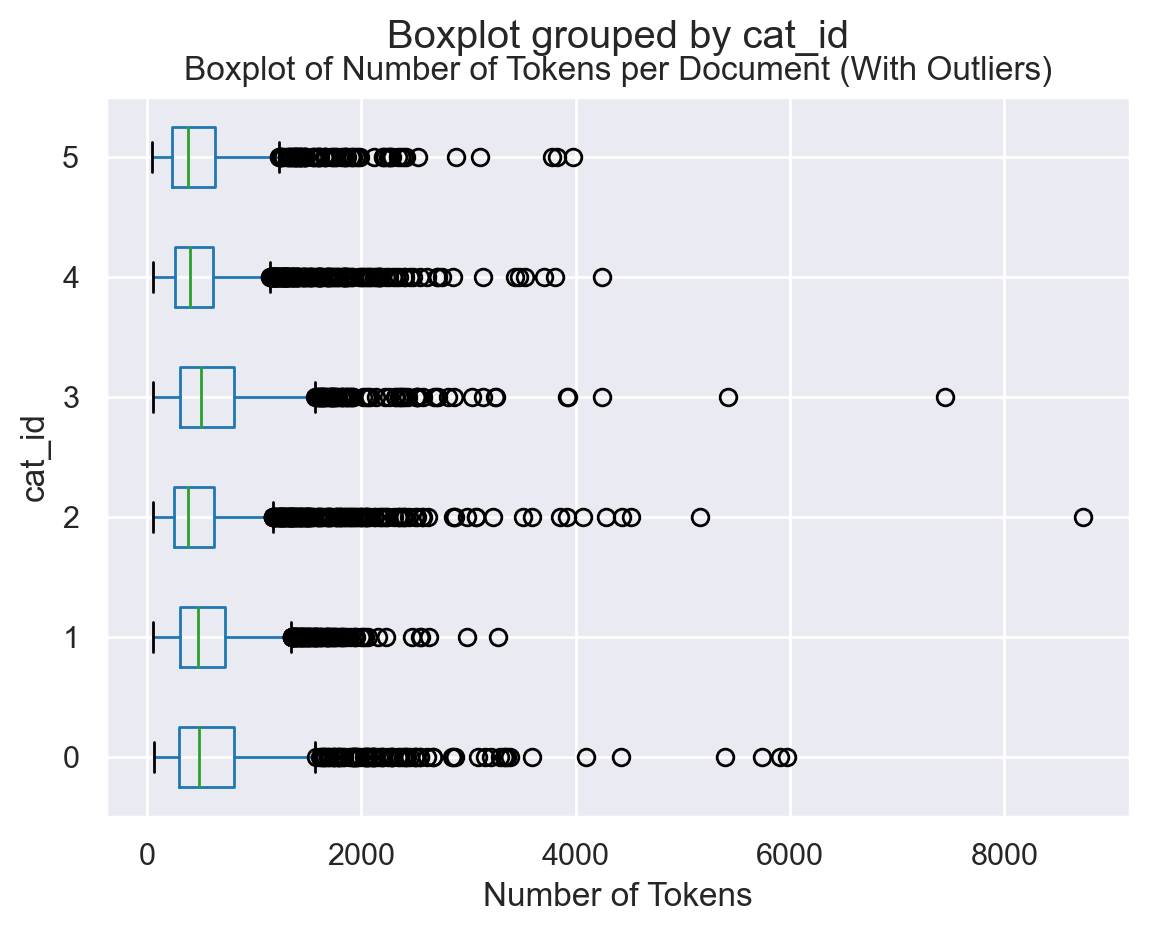

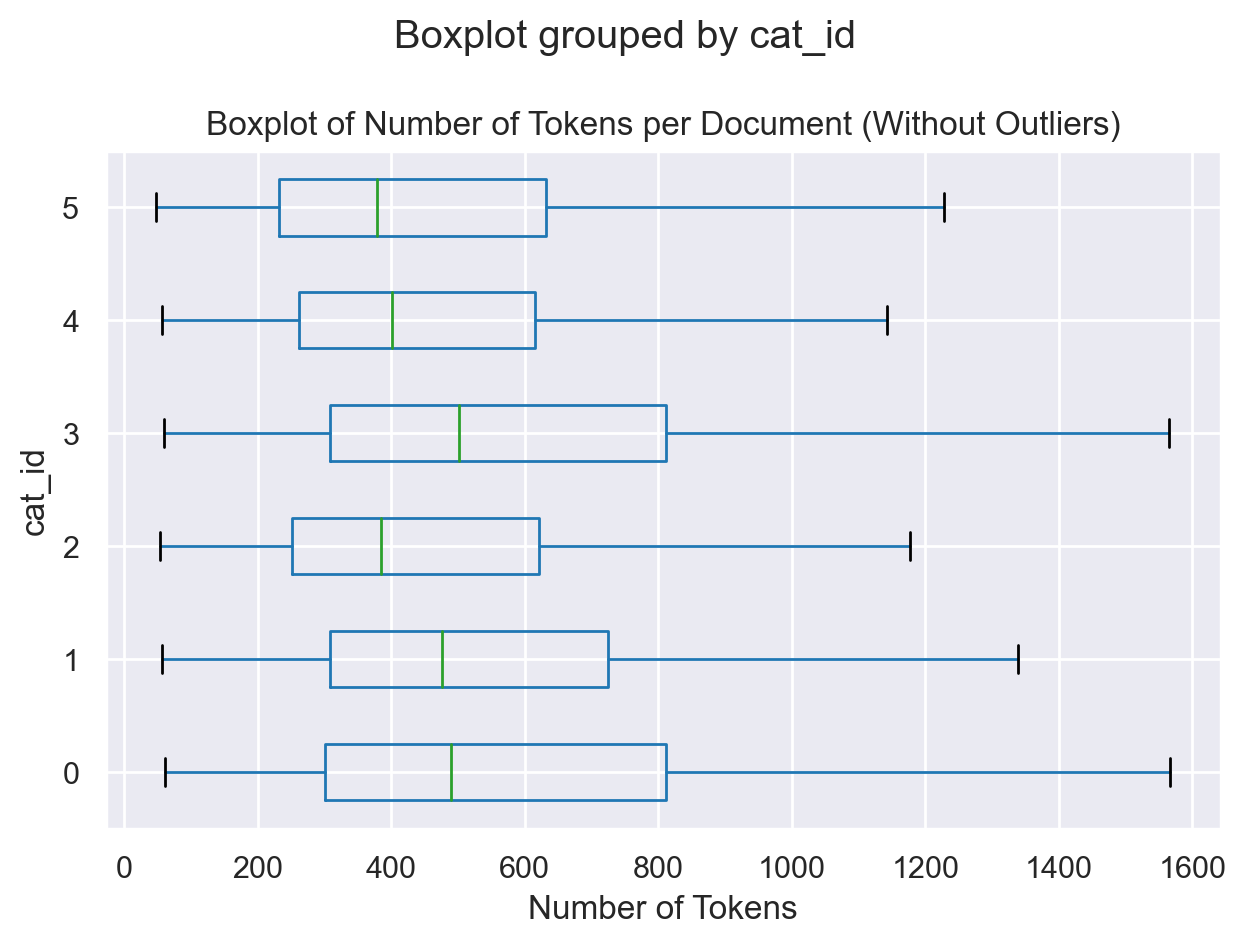

In [24]:

# Draw a box diagram containing outliers
plt.figure(figsize=(10, 6))

doc_df.boxplot(column='tokens_n', by='cat_id',vert=False, showfliers=True)
plt.title('Boxplot of Number of Tokens per Document (With Outliers)')
plt.xlabel('Number of Tokens')

# Draw a box diagram that does not contain outliers

doc_df.boxplot(column='tokens_n',by='cat_id',vert=False, showfliers=False)
plt.title('Boxplot of Number of Tokens per Document (Without Outliers)')
plt.xlabel('Number of Tokens')

plt.tight_layout()
plt.show()

**<h5>2. Explication boxplot:</h5>** <br>
Median: The horizontal line in the box represents the median of the data, that is, the middle value of all data points after sorting.

Upper Quartile (Q3): The upper edge of the box represents the third quartile of the data, that is, the median of the part above the median of the data, which represents the value before the largest 25% of the data.

Lower Quartile (Q1): The lower edge of the box represents the first quartile of the data, that is, the median of the part below the median of the data, which represents the value after the smallest 25% of the data.

Interquartile Range (IQR): The difference between the upper quartile and the lower quartile, representing the middle 50% of the data.

Outliers: Represented as points on a boxplot, usually those values less than Q1 - 1.5 * IQR or greater than Q3 + 1.5 * IQR. These points represent possible outliers, which have unusually high or low values compared to other data points.

"Whiskers": Lines extending outside the box, representing the minimum and maximum values excluding outliers. In many boxplot conventions, the whiskers extend to the data points closest to Q1 - 1.5 * IQR and Q3 + 1.5 * IQR.

#### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [25]:
# calculate the number of tokens in the document with the most tokens
doc_df['text_length'] = doc_df['text'].apply(len)
# trouver l'index du document avec le texte le plus long
max_length_idx = doc_df[doc_df['category']=='robotics']['text_length'].idxmax()
# obtenir le document avec le plus de tokens
longest_text_document = doc_df.loc[max_length_idx]
longest_text_document

text           Q:\n\n6DOF Kinematics moveo\n\nI asked on stac...
category                                                robotics
cat_id                                                         2
tokens         [Q, :, 6DOF, Kinematics, moveo, I, asked, on, ...
tokens_n                                                    8734
text_length                                                27125
Name: robotics.stackexchange_0000022063, dtype: object

In [26]:
print(longest_text_document.text)

Q:

6DOF Kinematics moveo

I asked on stackoverflow for the DH-Parameter for my robotic arm (moveo bcn3d).
I also copied the arduino code of Skyentific (YouTuber). Modified it to match my settings but i still does not work. Can someone please help me??? I am getting depressed if this keeps going like that.
In the home position, all joints have angle 0.
If I tell the forward kinematic that I want the 3rd joint and the 5th joint rotated 90 degrees, the values should be: (224, 0, 280) {x, y, z} should come out + some euler angles (can be ignored for now).
But I don't understand why these values come out, because the r and d values of the DH matrix are correct(https://stackoverflow.com/questions/67159164/denavit-hartenberg-6dof-moveo-inverse-kinematic-robot-arm?noredirect=1#comment118726837_67159164)
Output of the Arduino:\
inverse:
0.00
0.00
-0.00
-180.00
180.00
-180.00
forward:
-224.00
0.00
280.00
45.00
180.00
45.00
In this example you can see that the inverse kinematic calculates three 

Explain it contains :
For topics related to programming or engineering of Arduino, the text might include chunks of code, technical specifications, or detailed procedural steps, all of which can significantly increase the length.

### Vectorizing again

#### 🚧 TODO: See how many features we get if we don't restrict their number

* Use again the `CountVectorizer` to vectorize the stackoverflow corpus

  * But use the whole vocabulary of the documents this time (**without** `vocabulary=words`)

  * Tell how many features are obtained

* Then limit the vocabulary to the 5000 most frequent words

* Apply and plot dimensionality reduction to 2 dimensions as prevously 
  (only on the limited vocabulary)

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [27]:
ys = doc_df.cat_id.values
ys

array([0, 0, 0, ..., 5, 5, 5])

In [28]:
vectorizer_complete = CountVectorizer()
xs = vectorizer_complete.fit_transform(doc_df['text'])
cv_complete_df = pd.DataFrame(xs.toarray(), columns=vectorizer_complete.get_feature_names_out(), index=doc_df.index)
cv_complete_df

,00,000,0000,00000,000000,0000000,00000000,0000000000000049,0000000000000184,0000000000000221,...,삼국유사,신증동국여지승람,조선글,ﬁnal,ﬁndings,ﬁnite,ﬁrst,ﬁve,ﬂexible,ﬂoating
id,,,,,,,,,,,,,,,,,,,,,
mythology.stackexchange_0000001634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mythology.stackexchange_0000002329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mythology.stackexchange_0000001146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mythology.stackexchange_0000004770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mythology.stackexchange_0000000516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
portuguese.stackexchange_0000001017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
portuguese.stackexchange_0000004609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
portuguese.stackexchange_0000000484,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# print the number of features
num_features = len(vectorizer_complete.get_feature_names_out())
print(f"Total number of features: {num_features}")

Total number of features: 153122


In [30]:
#this is manual way 
column_sums = cv_complete_df.sum().sort_values(ascending=False)[:5000].index
cv_complete_df_2 = cv_complete_df[column_sums]
cv_complete_df_2
#cv_complete_df.sum().sort_values(ascending=False)[:5000]

,the,of,to,and,in,is,that,it,for,you,...,presents,cites,denote,poder,rob,safer,i2c,ce,bottle,conjugação
id,,,,,,,,,,,,,,,,,,,,,
mythology.stackexchange_0000001634,4,1,0,5,0,4,1,6,0,0,...,0,0,0,0,0,0,0,0,0,0
mythology.stackexchange_0000002329,17,11,15,8,11,17,6,8,1,0,...,0,0,0,0,0,0,0,0,0,0
mythology.stackexchange_0000001146,41,19,12,21,8,10,5,5,6,1,...,0,0,0,0,0,0,0,0,0,0
mythology.stackexchange_0000004770,36,19,22,19,9,3,7,6,3,6,...,0,0,0,0,0,0,0,0,0,0
mythology.stackexchange_0000000516,93,59,24,33,25,18,15,8,8,3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
portuguese.stackexchange_0000001017,42,20,18,17,22,15,5,4,9,9,...,0,0,0,4,0,0,0,0,0,0
portuguese.stackexchange_0000004609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
portuguese.stackexchange_0000000484,26,7,23,34,20,17,11,8,7,7,...,0,0,0,0,0,0,0,0,0,0


In [31]:
vectorizer_complete2 = CountVectorizer(max_features=5000)
xs = vectorizer_complete2.fit_transform(doc_df['text'])
#cv_complete_df_5000 = pd.DataFrame(xs.toarray(), columns=vectorizer_complete2.get_feature_names_out(), index=doc_df.index)
# sorted_index= cv_complete_df_5000.sum(axis=0).sort_values(ascending=False).index
# cv_complete_df_5000[sorted_index]
num_features_5000 = len(vectorizer_complete2.get_feature_names_out())
print(f"Total number of features: {num_features_5000}")


Total number of features: 5000


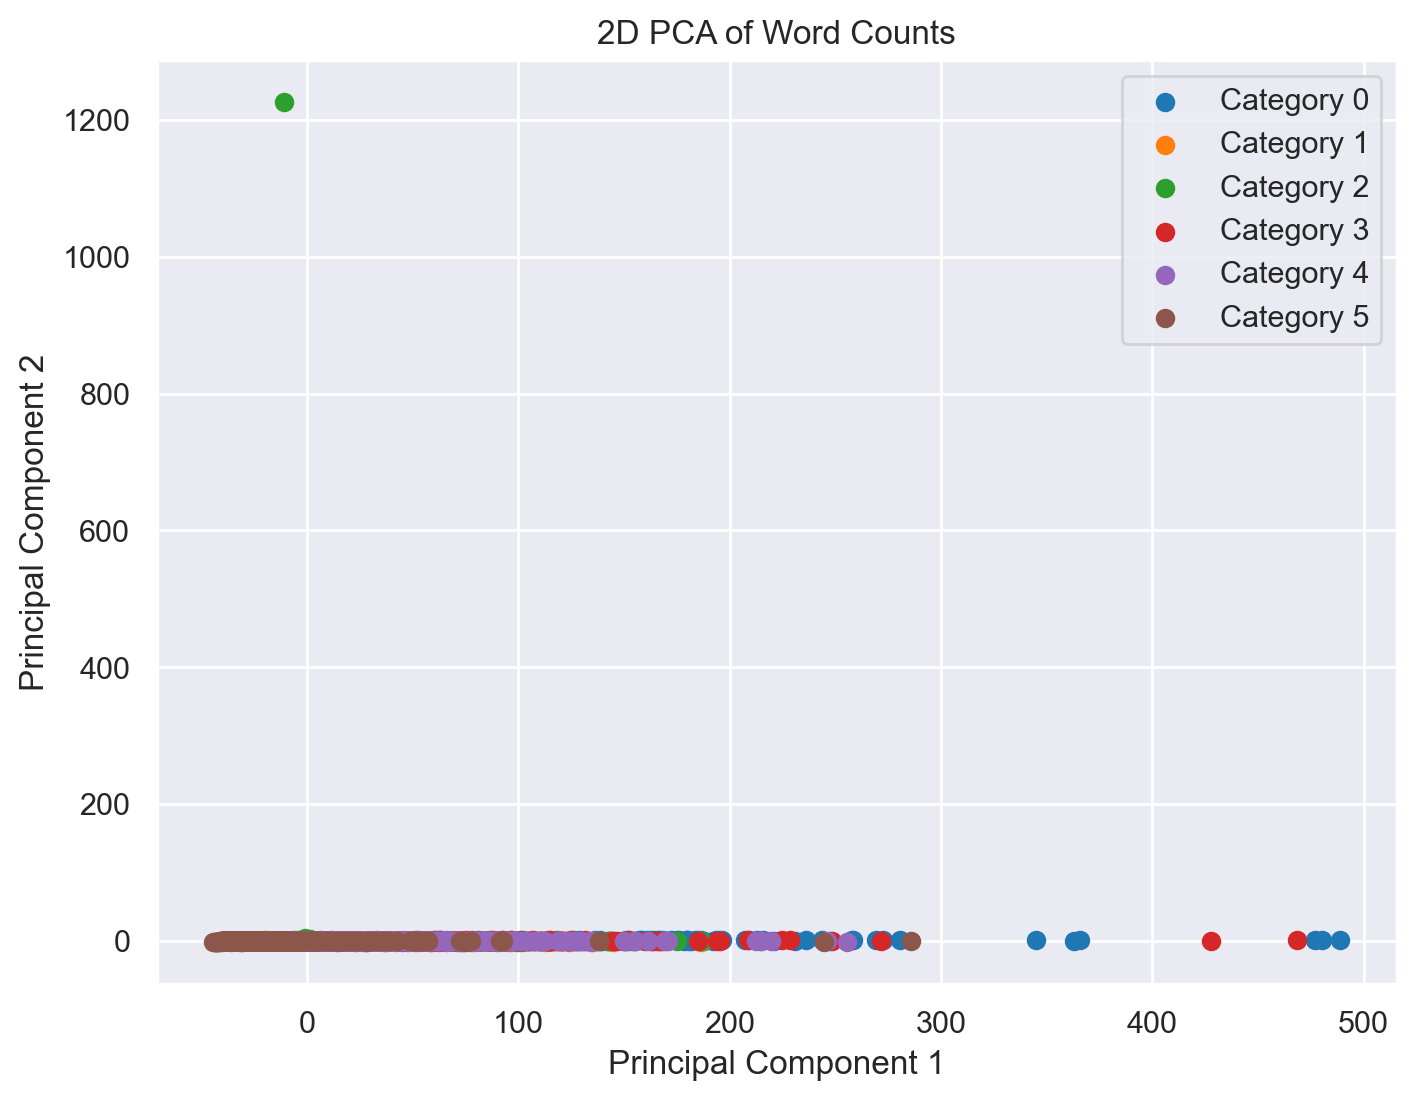

In [32]:
# Standardizing the data
# scaler = StandardScaler()
# wc_df_standardized_5000 = scaler.fit_transform(xs.toarray())
# Applying PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(xs.toarray())
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

#Plotting the 2D vectors
plt.figure(figsize=(8, 6))
unique_ids = np.unique(doc_df['cat_id'])
# Plot scatter plots for each category
for cat_id in unique_ids:
    # choose indices of the current category
    idx = doc_df['cat_id'] == cat_id
    plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=f'Category {cat_id}')
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Word Counts')
plt.grid(True)
plt.show()

#### 🚧 TODO: Find that outlier!

* Use pandas to find the document corresponding to the outlier

* Print the correspoding text
  
* Tell what it contains (if you could figure it out)


In [33]:
outlier_index = reduced_df['PC2'].idxmax()
print(doc_df.iloc[outlier_index].text)

Q:

arduino -lcd screen has weird noise with multiple pictures

I'm connecting an arduino to a lcd screen using the following library. For the display code I have written a simple piece of code that should display 2 picture os eyes (1 angry one friendly) and switching at regular intervals, however the display keeps showing me weird pixels around the borders that shouldn't be there, by making it show the same eyes twice this can be fixed however as long as I have both eyes being used it runs into trouble. Here is my code: 
    void setup()
    {
      LCDA.initDriverPin(2,7,10); 
      LCDA.Initialise(); // INIT SCREEN  
      delay(100);
    }
    void loop(){
      LCDA.CLEAR(); //empty screen 
      delay(100);//wait for command to finish 

      LCDA.DrawFullScreen(eyes);
      delay(5000); //wait 5 seconds with eyes on the screen 

      LCDA.CLEAR();//clear screen
      delay(100);//wait for command to finish 
      LCDA.DrawFullScreen(angry); //show me the angry face 
      delay

### Explanation : ###
The provided text includes chunks of code, technical specifications about topics related to programming and engineering of Arduino, in fact, there is an image representation in hex.

#### 🚧 TODO: The reason for this outlier is...

*   Give a short explanation

*   Remove the outlier from the dataframe 

*   Redo the dimensional reduction

*   Plot the 2D vectors and color them by category

### Explanation : ###

There could be various reasons to explain the existence of this outlier, in particular the 3 following ones:

1.Measurement or data entry errors.<br>
2.A data point that is significantly different from the data it is being compared to (e.g., a very long document in a collection of short texts).<br>
3.A data point representing a rare event or a unique instance in the dataset.<br>

However, the most likely reason is the third one, in which the outlier's content features a conversation via Stackoverflow in which the exchanged information is quite large due to the topic of it (Arduino and coding), compared to the rest of samples.

In [40]:
doc_df.drop(doc_df.index[outlier_index], inplace=True)
doc_df.reset_index(drop=True, inplace=True)

In [41]:
vectorizer_complete2 = CountVectorizer(max_features=5000)
xs = vectorizer_complete2.fit_transform(doc_df['text'])
# cv_complete_df_5000 = pd.DataFrame(xs.toarray(), columns=vectorizer_complete2.get_feature_names_out(), index=doc_df.index)
# sorted_index= cv_complete_df_5000.sum(axis=0).sort_values(ascending=False).index
# cv_complete_df_5000[sorted_index]

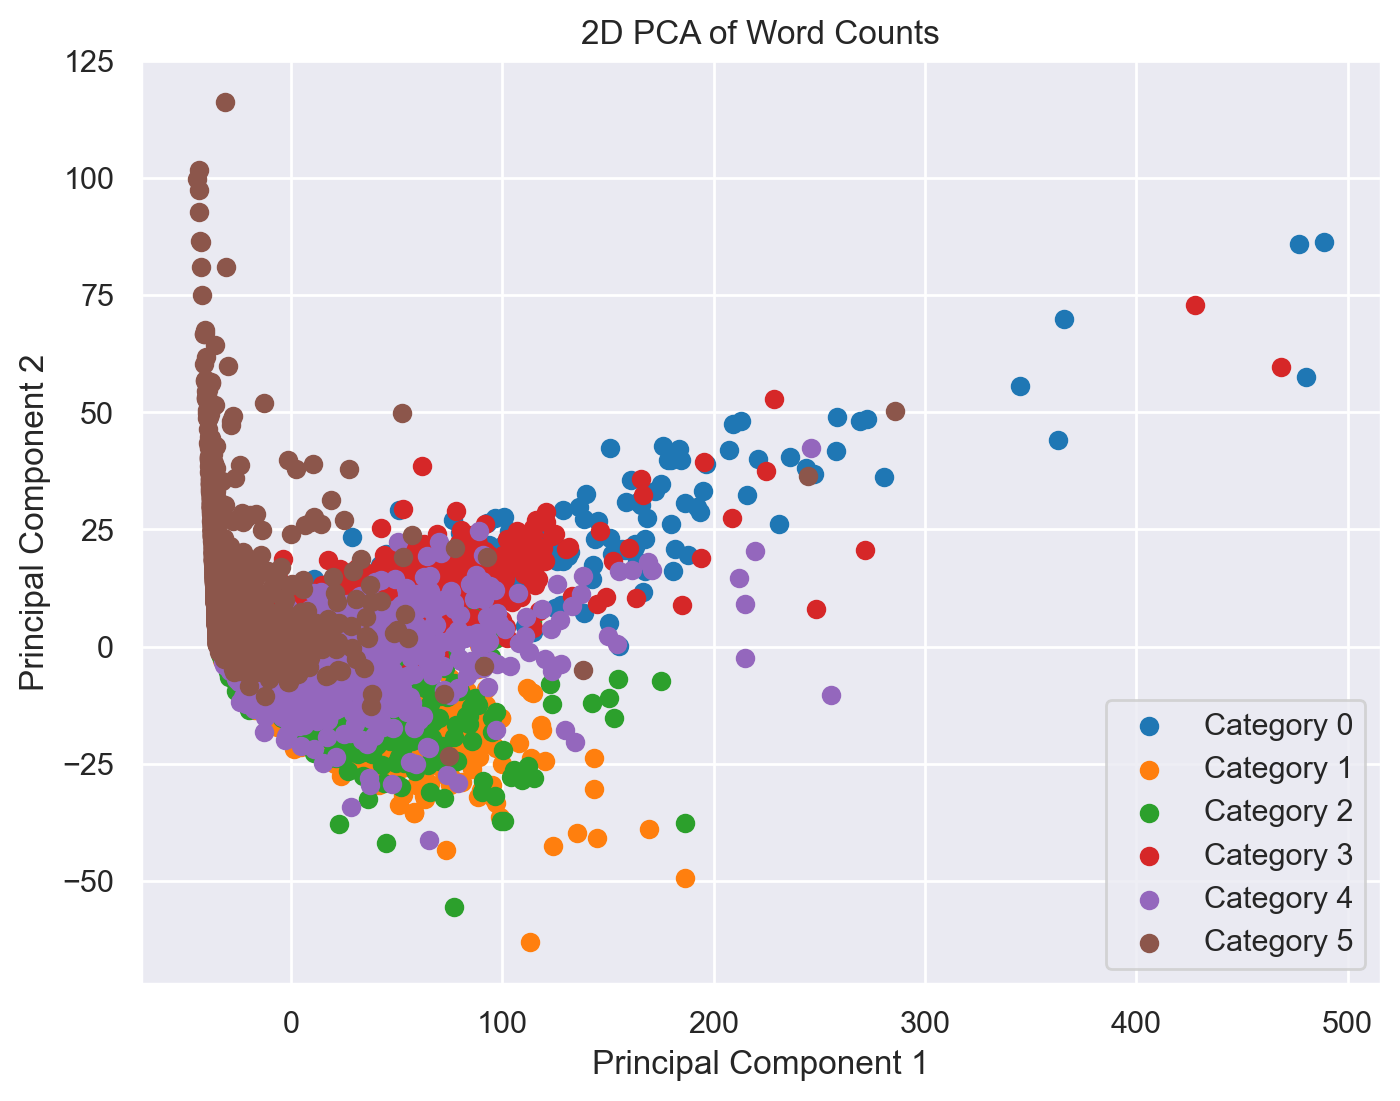

In [42]:
# Standardizing the data
#scaler = StandardScaler()
#wc_df_standardized_5000 = scaler.fit_transform(cv_complete_df_5000)
# Applying PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(xs.toarray())


# print(reduced_data)
# Plotting the 2D vectors
plt.figure(figsize=(8, 6))
unique_ids = np.unique(doc_df['cat_id'])
# Plot scatter plots for each category
for cat_id in unique_ids:
    # choose indices of the current category
    idx = doc_df['cat_id'] == cat_id
    plt.scatter(reduced_data[idx, 0], reduced_data[idx, 1], label=f'Category {cat_id}')
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA of Word Counts')
plt.grid(True)
plt.show()

## Train models to predict text subjects

### Split the data in training and test sets

In [36]:
train_xs, test_xs, train_ys, test_ys = model_selection.train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(10115, 5000)
(4336, 5000)


### 🚧 TODO: Apply different algorithms to try predicting the category

* E.g., Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest, Support Vector Classifer.

* You could investigate [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements linear classifiers (e.g, SVM, logistic regression) with SGD training (faster).

* Present a table with the results of the different algorithms (e.g., accuracy, precision, recall, f1-score) and their execution time

* (Optional) Analyse 1 algorythm in detail (e.g., Logistic Regression)

  *   Try different parameters (possibly with a grid search)

  *   Present the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

  *   Present the confusion matrix of the best model

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [39]:
logistic_regression_model = LogisticRegression(max_iter=1000)
multinomial_nb_model = MultinomialNB()
decision_tree_model = DecisionTreeClassifier()
random_forest_model = RandomForestClassifier(n_estimators=100)
support_vector_classifier = SVC()

#Train and evaluate the classifiers
classifiers = {
    'Logistic Regression': logistic_regression_model,
    'Multinomial Naive Bayes': multinomial_nb_model,
    'Decision Tree': decision_tree_model,
    'Random Forest': random_forest_model,
    'Support Vector Classifier': support_vector_classifier
}

for name, clf in classifiers.items():
    # Train the model
    clf.fit(train_xs, train_ys)

    #Predict on the test set
    y_pred = clf.predict(test_xs)

    #valuate the model
    accuracy = accuracy_score(test_ys, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')
    print(classification_report(test_ys, y_pred))


Logistic Regression Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       420
           1       0.98      0.99      0.98       692
           2       0.99      0.98      0.98       927
           3       0.97      0.97      0.97       705
           4       0.98      0.98      0.98      1032
           5       1.00      0.99      0.99       560

    accuracy                           0.98      4336
   macro avg       0.98      0.98      0.98      4336
weighted avg       0.98      0.98      0.98      4336

Multinomial Naive Bayes Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       420
           1       0.96      1.00      0.98       692
           2       0.99      0.97      0.98       927
           3       0.96      0.97      0.96       705
           4       0.99      0.98      0.98      1032
           5       1.00      0.93      0.96       560

   

In [ ]:
from sklearn.linear_model import SGDClassifier

# create SGDClassifier instances
sgd_logistic_regression = SGDClassifier(loss='log_loss', max_iter=1000)
sgd_svm = SGDClassifier(loss='hinge', max_iter=1000)

# put the classifiers in a dictionary
classifiers['SGD Logistic Regression'] = sgd_logistic_regression
classifiers['SGD SVM'] = sgd_svm

# Train and evaluate the classifiers    
for name, clf in classifiers.items():
    # train the model
    clf.fit(train_xs, train_ys)

    # predict on the test set
    y_pred = clf.predict(test_xs)

    # evolute the model
    accuracy = accuracy_score(test_ys, y_pred)
    print(f'{name} Accuracy: {accuracy:.2f}')
    print(classification_report(test_ys, y_pred))


Logistic Regression Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       420
           1       0.99      0.98      0.99       692
           2       0.99      0.97      0.98       927
           3       0.97      0.97      0.97       705
           4       0.98      0.98      0.98      1032
           5       1.00      0.99      1.00       560

    accuracy                           0.98      4336
   macro avg       0.98      0.98      0.98      4336
weighted avg       0.98      0.98      0.98      4336

Multinomial Naive Bayes Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.90      0.99      0.94       420
           1       0.92      0.99      0.96       692
           2       0.99      0.93      0.96       927
           3       0.95      0.96      0.96       705
           4       0.98      0.98      0.98      1032
           5       1.00      0.92      0.96       560

   

/Users/chenchenjunjie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chenchenjunjie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chenchenjunjie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chenchenjunjie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chenchenjunjie/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chenchenjunji

Best Parameters: {'C': 0.615848211066026, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       420
           1       0.98      0.99      0.98       692
           2       0.99      0.98      0.98       927
           3       0.97      0.98      0.98       705
           4       0.98      0.99      0.98      1032
           5       1.00      0.99      1.00       560

    accuracy                           0.98      4336
   macro avg       0.98      0.98      0.98      4336
weighted avg       0.98      0.98      0.98      4336



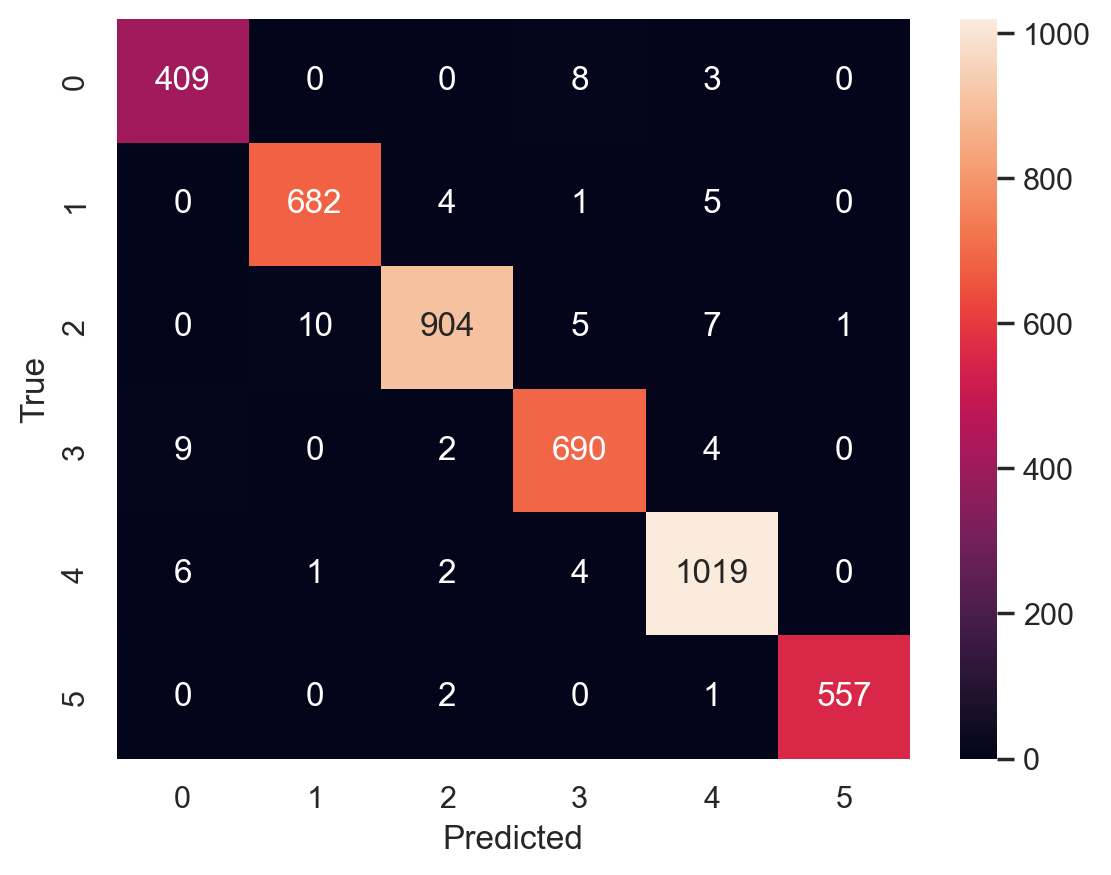

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
# set the parameter grid
param_grid = {
    'C': np.logspace(-4, 4, 20),  # inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # algorithm to use in the optimization problem
}

# create a grid search object
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# execute the grid search
grid_search.fit(train_xs, train_ys)

# access the best parameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# predict on the test set
y_pred = best_model.predict(test_xs)

# print the classification report
print(classification_report(test_ys, y_pred))

# print the confusion matrix
cm = confusion_matrix(test_ys, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### 🚧 TODO: Explain what model seems to work best

**Considering obtained results on metrics, the Logistic Regression model appears to be the best. It has the highest accuracy and shows a balanced performance in terms of precision, recall, and F1-score across different categories.**

____